# Anova Analysis of ~55k genes dataset


Import all requisite libraries. 

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import patsy

from sklearn import manifold
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA

from time import time

Load the data

In [17]:
#load the data 
df = pd.read_csv('genename_norm.tsv', sep='\t')
dfn = pd.DataFrame()
##dfn['age'] = df['age']
##dfn['mgs_level'] = df['mgs_level']
df.rename(columns={df.columns[0]: "gene" }, inplace = True)
df = df.set_index('gene')

## See whether we have the table in the right format
df.head()

,100_2,101_3,102_2,103_3,104_2,105_2,106_4,107_4,109_1,11_4,...,90_2,91_2,92_3,93_2,94_4,95_4,96_3,97_2,98_3,99_1
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,14.004157,15.591177,14.495233,14.146105,14.906343,10.979150,14.834945,27.516201,20.823631,22.148596,...,10.937974,17.380791,18.089617,14.911962,24.344427,14.048984,29.635023,12.572984,14.349935,16.764118
DPM1,15.809138,18.622794,18.438789,22.497419,22.107475,12.703149,19.156937,25.253356,19.814557,27.092479,...,30.576609,17.264141,25.772841,18.062377,29.177512,29.234282,27.439837,19.257355,24.429057,20.779476
SCYL3,26.327193,31.553572,28.990467,25.650467,30.028720,10.525466,23.128497,25.162842,22.291376,29.366665,...,22.704582,19.013885,22.077113,20.162653,37.411656,34.915857,25.336116,27.214939,29.297785,14.053752
C1orf112,16.929470,19.179622,21.742850,19.088719,16.346569,13.519780,29.553079,15.477863,25.135132,19.577777,...,23.201763,19.597133,29.954850,18.062377,25.418446,26.858351,16.372436,16.710928,19.218664,12.447609
FGR,1.307055,0.742437,2.238235,0.937392,1.152181,3.085050,1.752159,1.719763,1.559479,1.779798,...,1.740132,1.633094,0.875304,4.410580,1.521527,1.136315,1.554924,2.307700,0.854163,1.204607


In [18]:
# Make sure to drop NA
dfn = df.dropna()

## Get the max library depth
max_ld = dfn.sum(axis=0).max()

## Multiply by max depth
new_df = dfn.multiply(max_ld)

## sum across the column, then divide by each library depth
dfn = new_df.div(dfn.sum(axis=0), axis=1)

dfn.head()
    

,100_2,101_3,102_2,103_3,104_2,105_2,106_4,107_4,109_1,11_4,...,90_2,91_2,92_3,93_2,94_4,95_4,96_3,97_2,98_3,99_1
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,16.110884,18.884343,16.823609,15.921594,16.823812,12.225675,15.985625,31.457432,24.027682,26.116206,...,13.129123,20.631651,20.263823,17.059386,26.464210,16.071976,35.970599,14.357550,16.191769,18.940736
DPM1,18.187398,22.556299,21.400620,25.321090,24.951257,14.145409,20.642854,28.870472,22.863345,31.945716,...,36.701867,20.493184,28.870500,20.663482,31.718134,33.443891,33.306110,21.990679,27.564560,23.477439
SCYL3,30.287746,38.218314,33.647218,28.869879,33.891447,11.720482,24.922470,28.766994,25.721263,34.627291,...,27.252877,22.570196,24.730579,23.066212,40.669264,39.943587,30.752642,31.077736,33.058196,15.878461
C1orf112,19.476269,23.230740,25.235414,21.484561,18.449301,15.054757,31.845379,17.694806,29.002576,23.084861,...,27.849655,23.262533,33.555147,20.663482,27.631748,30.725836,19.872646,19.082820,21.685406,14.063780
FGR,1.503683,0.899254,2.597763,1.055045,1.300391,3.435314,1.888066,1.966090,1.799430,2.098624,...,2.088724,1.938544,0.980508,5.045734,1.654013,1.299939,1.887346,2.635247,0.963796,1.361011


### When row is standardized using mean and sigma, we get all NaN for p values. It could be that that messes up the variance, but I'm not exactly sure why.

In [19]:
## This gave me NaN's for all p-values
# ## Mean across row
# ave = dfn.mean(axis=1)

# ## Sigma across row
# sig = dfn.std(axis=1)

# ## Subtract the mean from the row
# df_sub = dfn.sub(dfn.mean(axis=1), axis=0)

# ## Divide by sigma
# dfn = df_sub.div(df_sub.std(axis=1), axis=0)

In [30]:
## Split the data into different groups for ANOVA testing
train_stage1 = {}
train_stage2 = {}
train_stage3 = {}
train_stage4 = {}

for col in dfn.columns:
    if '_1' in col:
        train_stage1[col] = dfn[col]
    elif '_2' in col:
        train_stage2[col] = dfn[col]
    elif '_3' in col:
        train_stage3[col] = dfn[col]
    elif '_4' in col:
        train_stage4[col] = dfn[col]


# train_stage1['gene'] = dfn['gene']
# train_stage2['gene'] = dfn['gene']
# train_stage3['gene'] = dfn['gene']
# train_stage4['gene'] = dfn['gene']

train_stage1 = pd.DataFrame(train_stage1).transpose()
train_stage2 = pd.DataFrame(train_stage2).transpose()
train_stage3 = pd.DataFrame(train_stage3).transpose()
train_stage4 = pd.DataFrame(train_stage4).transpose()

train_stage1.head()

,0,1,2,3,4,5,6,7,8,9,...,18610,18611,18612,18613,18614,18615,18616,18617,18618,18619
109_1,24.027682,22.863345,25.721263,29.002576,1.799430,19.023149,12.807707,36.517842,74.305870,36.306144,...,0.000000,2.141322,3.161704,0.287909,0.0,0.446682,0.693310,0.423395,1.693581,3.069616
115_1,18.243837,26.837459,34.092730,19.018672,0.986153,7.900497,10.002413,37.896465,70.087328,42.897671,...,0.155671,1.303131,3.921368,1.892006,0.0,0.717779,0.726232,0.352198,2.254065,1.549670
117_1,17.914393,29.186370,34.319145,31.199223,2.214138,31.572607,11.171335,42.169273,69.443432,36.130713,...,0.438802,1.759234,2.010840,0.580708,0.0,1.047690,0.979253,0.301928,2.214138,2.717352
119_1,21.142220,27.565173,21.142220,42.150628,2.140984,25.156566,13.782586,45.629728,102.633435,35.460052,...,0.527217,1.591019,6.604937,2.284163,0.0,0.000000,0.535246,0.267623,0.936681,2.408607
120_1,18.306136,28.505269,20.529024,20.529024,1.999292,21.444331,9.414584,42.496388,59.102669,35.696966,...,0.910076,2.701463,3.199651,0.623716,0.0,1.957449,0.523032,0.261516,0.392274,1.176823


# ANOVA Analysis

In [21]:
## Perform Anova analysis
stats.f_oneway(train_stage1, train_stage2, train_stage3, train_stage4)

F_onewayResult(statistic=array([7.48924519, 1.36014452, 1.87313499, ..., 3.44893161, 1.40222579,
       4.16205923]), pvalue=array([6.68776542e-05, 2.54370205e-01, 1.33311103e-01, ...,
       1.66268102e-02, 2.41489349e-01, 6.33592230e-03]))

In [22]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage1, train_stage2, train_stage3, train_stage4).pvalue

dfn = dfn.reset_index()

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard_all = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal_all = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard_all))
print(len(list(threshold_liberal_all)))

4678
6858


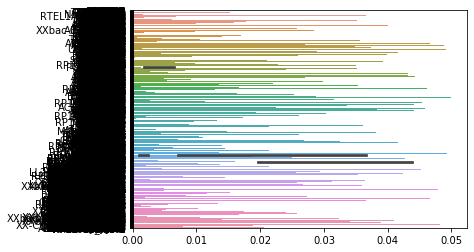

In [8]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard_all]
x = [i[1] for i in threshold_standard_all]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [23]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage1, train_stage2).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard12 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal12 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard12))
print(len(list(threshold_liberal12)))

3344
5345


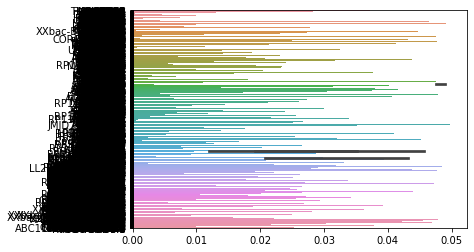

In [11]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard12]
x = [i[1] for i in threshold_standard12]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [24]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage1, train_stage3).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard13 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal13 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard13))
print(len(list(threshold_liberal13)))

746
1400


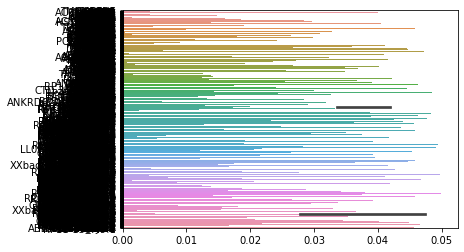

In [13]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard13]
x = [i[1] for i in threshold_standard13]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [25]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage1, train_stage4).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard14 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal14 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard14))
print(len(list(threshold_liberal14)))

2735
3933


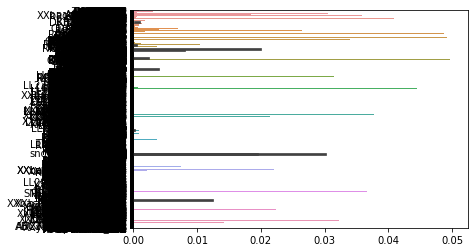

In [15]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard14]
x = [i[1] for i in threshold_standard14]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [26]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage2, train_stage3).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard23 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal23 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard23))
print(len(list(threshold_liberal23)))

5312
7496


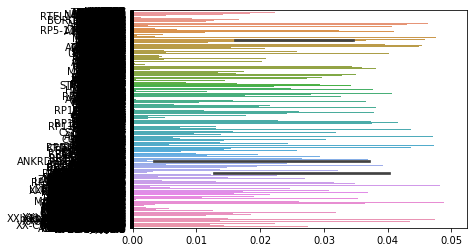

In [17]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard23]
x = [i[1] for i in threshold_standard23]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [27]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage2, train_stage4).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard24 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal24 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard24))
print(len(list(threshold_liberal24)))

3160
4968


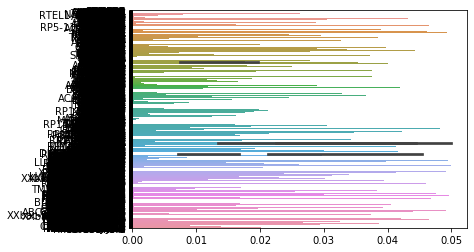

In [19]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard24]
x = [i[1] for i in threshold_standard24]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [28]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage3, train_stage4).pvalue

## Get the list of genes that these values correspond to
gene_list = dfn['gene']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard34 = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
threshold_liberal34 = list(filter(lambda x: x[1] <= 0.1, pairs))

print(len(threshold_standard14))
print(len(list(threshold_liberal14)))

2735
3933


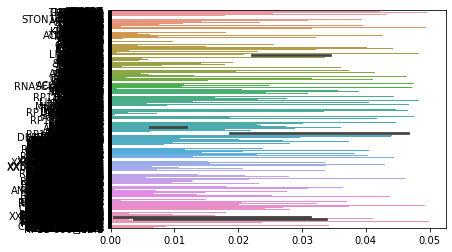

In [21]:
## Plot the genes that are available
y = [i[0] for i in threshold_standard34]
x = [i[1] for i in threshold_standard34]

# sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x, y)

In [29]:
## Check how many genes are similar between 1/2 and all
print(len(set(threshold_standard12).difference(set(threshold_standard_all))), " out of:", len(threshold_standard12))

## Check how many genes are similar between 1/3 and all
print(len(set(threshold_standard13).difference(set(threshold_standard_all))), " out of:", len(threshold_standard13))

## Check how many genes are similar between 1/4 and all
print(len(set(threshold_standard14).difference(set(threshold_standard_all))), " out of:", len(threshold_standard14))

## Check how many genes are similar between 2/3 and all
print(len(set(threshold_standard23).difference(set(threshold_standard_all))), " out of:", len(threshold_standard23))

## Check how many genes are similar between 2/4 and all
print(len(set(threshold_standard24).difference(set(threshold_standard_all))), " out of:", len(threshold_standard24))

## Check how many genes are similar between 3/4 and all
print(len(set(threshold_standard34).difference(set(threshold_standard_all))), " out of:", len(threshold_standard34))

3344  out of: 3344
746  out of: 746
2735  out of: 2735
5312  out of: 5312
3160  out of: 3160
1321  out of: 1321


In [31]:
## Total number of genes that show significant variance
print(len(set(threshold_standard12).union(set(threshold_standard13)).union(set(threshold_standard14)).union(set(threshold_standard23)).union(set(threshold_standard24)).union(set(threshold_standard34))))

16618


In [23]:
# Create and print correlation matrix:
corr = train_stage1.corr()
print(corr)

gene              TSPAN6      TNMD      DPM1     SCYL3  C1orf112       FGR  \
gene                                                                         
TSPAN6          1.000000  0.047169  0.518782  0.117246  0.209996 -0.036858   
TNMD            0.047169  1.000000  0.039521  0.009718  0.087072 -0.094728   
DPM1            0.518782  0.039521  1.000000  0.435903  0.255872 -0.127359   
SCYL3           0.117246  0.009718  0.435903  1.000000  0.102972 -0.157759   
C1orf112        0.209996  0.087072  0.255872  0.102972  1.000000 -0.127130   
...                  ...       ...       ...       ...       ...       ...   
CTD-2331H12.9        NaN       NaN       NaN       NaN       NaN       NaN   
RP11-122G18.12 -0.198805  0.037113 -0.040566 -0.122227 -0.216350  0.197114   
RP5-937E21.8   -0.087727  0.075245 -0.083679  0.037575 -0.043481 -0.022494   
RP11-606M12.1  -0.075087  0.176283 -0.022183  0.031241  0.031029  0.021096   
MIR4481              NaN       NaN       NaN       NaN       NaN